In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

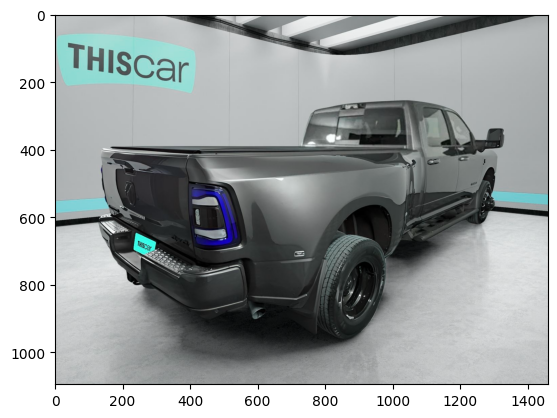

In [2]:
# Load data
name = "1"
image_orig = cv2.imread(f"../data/assignment/images/{name}.jpeg")
car_mask = cv2.imread(f"../data/assignment/car_masks/{name}.png")
car_mask = cv2.medianBlur(car_mask, 3)
shadow_mask = cv2.imread(f"../data/assignment/shadow_masks/{name}.png")
wall_image = cv2.imread("../data/assignment/wall.png")
floor_image = cv2.imread("../data/assignment/floor.png")
sample = cv2.imread("../data/assignment/sample-output.jpg")

plt.imshow(image_orig)

In [3]:
# Make bg mask
gray = cv2.cvtColor(car_mask, cv2.COLOR_BGR2GRAY)
car_mask_gray = cv2.bitwise_not(gray)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10, 10))
car_mask_processed = cv2.morphologyEx(car_mask_gray,cv2.MORPH_OPEN,kernel)
bg_mask = car_mask_processed == 255

In [4]:
# Calculate aspect ratio for getting background without distortion
h, w, _ = image_orig.shape
aspect_ratio = w / h
aspect_ratio

1.3333333333333333

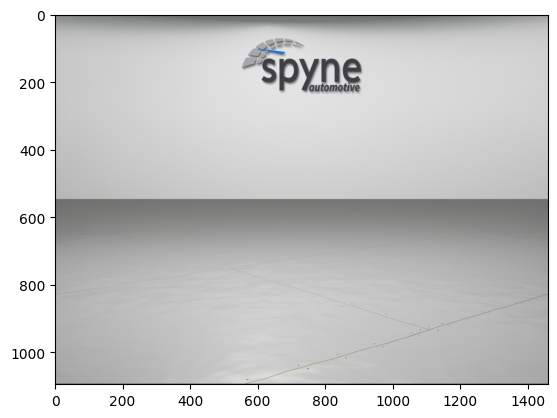

In [5]:
# Calculate background by using parts of wall and floor image
wall_height = 900
floor_height = 2160 - wall_height
wall_width = int(aspect_ratio * 2160)
floor_width = int(aspect_ratio * 2160)
wall_startx = (3840 - wall_width) // 2
floor_startx = (3840 - floor_width) // 2
wall_starty = 600
floor_starty = 1260

wall = wall_image[wall_starty: wall_starty + wall_height, wall_startx: wall_startx + wall_width, :]
floor = floor_image[floor_starty: floor_starty + floor_height, floor_startx: floor_startx + floor_width, :]

bg = np.concatenate([wall, floor])
bg = cv2.resize(bg, (w, h))
plt.imshow(bg)

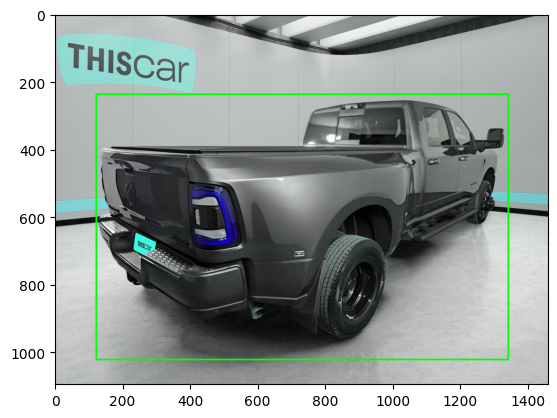

In [6]:
# Getting car bounding box to place car properly
h1, w1 = bg.shape[:2]
h2, w2 = image_orig.shape[:2]

x, y, w, h = cv2.boundingRect(255 - car_mask_processed)
x_buffer = 10
y_buffer = 80

if h < h1 / 2: 
    y_buffer = 160
    
startx = x - x_buffer
starty = y - 20
width  = w + 2 * x_buffer
height = h + y_buffer
rect1 = cv2.rectangle(image_orig.copy(),(startx,starty),(startx+width,starty+height),(0,255,0),3)
plt.imshow(rect1)

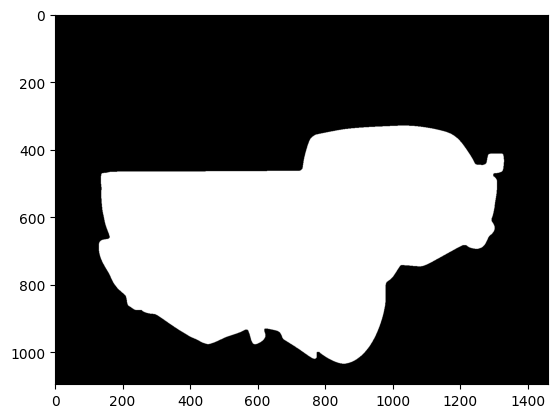

In [7]:
# Get shifted car bg mask
bg_result_mask = np.zeros((h1, w1, 3), dtype=np.bool)
x_bg = (w1 - width) // 2
y_bg = h1 - height
bg_result_mask[y_bg:, x_bg: x_bg + width, :] = ~bg_mask[starty: starty+height, startx: startx + width, np.newaxis]
plt.imshow(bg_result_mask * 255)

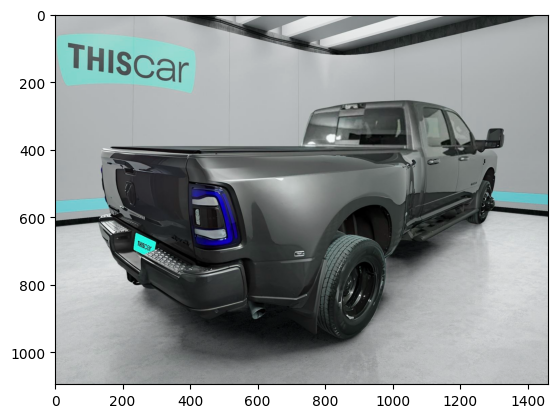

In [8]:
# Color correction for the car and bg
hsv = cv2.cvtColor(image_orig, cv2.COLOR_BGR2HSV) 
  
# Split the LAB image into separate channels 
h, s, v = cv2.split(hsv) 
  
# Apply CLAHE to the L channel 
# clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(3, 3)) 
# v = clahe.apply(v)
h = np.clip(h * 1.0, 0, 255).astype(np.uint8)
s = np.clip(s * 1.1, 0, 255).astype(np.uint8)
v = np.clip(v * 0.98, 0, 255).astype(np.uint8)
  
# Merge the LAB channels back together 
hsv = cv2.merge((h, s, v)) 
  
# Convert the LAB image back to RGB color space 
output = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
plt.imshow(output)

hsv = cv2.cvtColor(bg.copy(), cv2.COLOR_BGR2HSV) 
  
# Split the LAB image into separate channels 
h, s, v = cv2.split(hsv) 
  
# Apply CLAHE to the L channel 
# clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(3, 3)) 
# v = clahe.apply(v)
h = np.clip(h * 1.0, 0, 255).astype(np.uint8)
s = np.clip(s * 1.0, 0, 255).astype(np.uint8)
v = np.clip(v * 1.1, 0, 255).astype(np.uint8)
  
# Merge the LAB channels back together 
hsv = cv2.merge((h, s, v)) 
  
# Convert the LAB image back to RGB color space 
result_image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

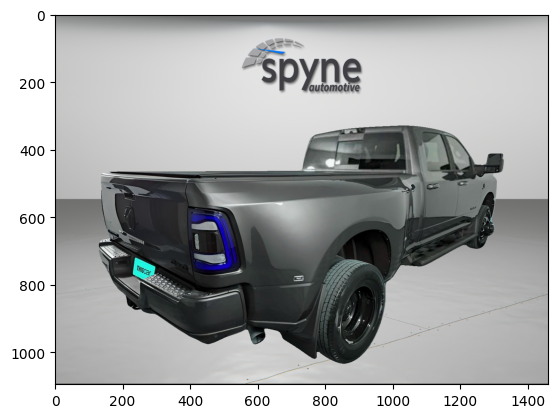

In [9]:
# Merging car and custom bg
result_image = bg.copy()
orig_mask = np.broadcast_to(bg_mask[:, :, np.newaxis], image_orig.shape)
result_image[bg_result_mask] = output[~orig_mask]
plt.imshow(result_image)

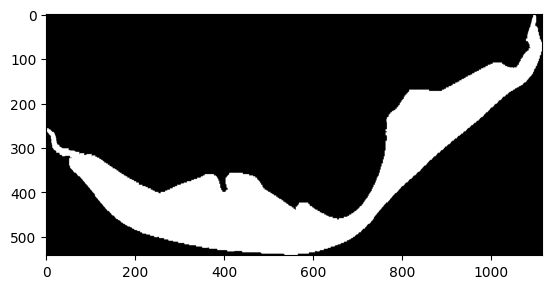

In [10]:
# Get shadow template
shadow_template = shadow_mask.copy()
shadow_template[shadow_mask != 0] = 255
plt.imshow(shadow_template)

In [11]:
# Match shadow template to get shadow position
image_without_bg = result_image.copy()
image_without_bg[~bg_result_mask] = 0
result = cv2.matchTemplate(image_without_bg, shadow_template, cv2.TM_CCOEFF)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
top_left = list(min_loc)
h, w, _ = shadow_template.shape
bottom_right = [top_left[0] + w, top_left[1] + h]

new_sh_mask = shadow_mask.copy()
new_sh_mask = cv2.dilate(new_sh_mask, np.ones((7, 7), np.uint8), iterations=5)
new_sh_mask = np.clip(new_sh_mask, 0, 120)

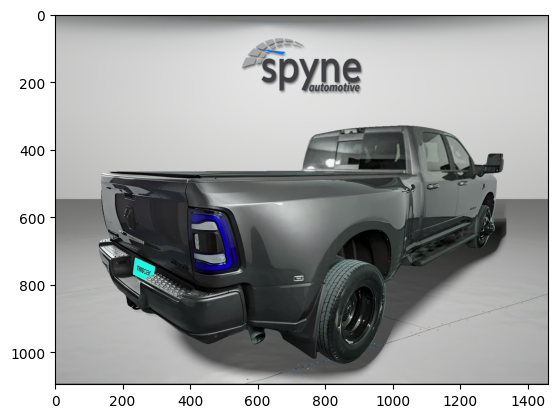

In [12]:
# Composite the final image
result_image = bg.copy()

result_image[
    top_left[1] : top_left[1] + h, top_left[0] : top_left[0] + w, :
] -= new_sh_mask
plt.imshow(result_image)


result_image[bg_result_mask] = output[~orig_mask]
final_image = np.clip(result_image, 0, 255)
plt.imshow(final_image)